In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS

# Load data
# df = pd.read_csv("../raw_data/filtered_data.csv")
#
# # Convert timestamp
# df['time'] = pd.to_datetime(df['time'], unit='s')
#
# # Check for missing data
# missing_data = df.isnull().sum()
#
# # Descriptive statistics
# ratings_distribution = df['rating'].value_counts()

clean_df = pd.read_csv("../raw_data/clean_data.csv")
clean_df['time'] = pd.to_datetime(clean_df['time'], unit='s')

generated_df = pd.read_csv("../raw_data/generated_data.csv")
generated_df['time'] = pd.to_datetime(generated_df['time'], unit='s')


def limit_data_to_positive(df):
    if 'to_be_removed' in df.columns:
        df = df[df['to_be_removed'].isna()]

    df_low_score = df[df['rating'] < 5]

    # Sample 500 reviews with a score of 5
    df_score_5_sample = df[df['rating'] == 5].sample(n=832, random_state=42)


    print(len(df_low_score))
    print(len(df_score_5_sample))
    df_filtered = pd.concat([df_low_score, df_score_5_sample])
    df_filtered.reset_index(drop=True, inplace=True)
    df = df_filtered
    df['time'] = pd.to_datetime(df['time'], unit='s')
    missing_data = df.isnull().sum()
    return df


clean_df = limit_data_to_positive(clean_df)







832
832


C:\Users\Sebastian\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\tools\datetimes.py:558: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


# Sentiment Analysis

          food  service  atmosphere
Positive  1235      784         632
Negative   306      282          99
NaN        123      598         933


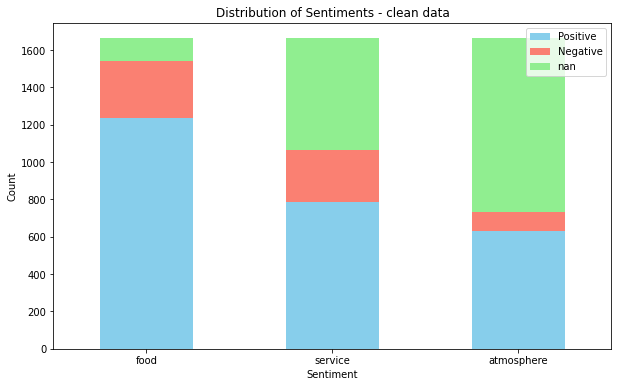

          food  service  atmosphere
NaN       2167     1315         790
Negative  2164     2177        2368
Positive     1      840        1174


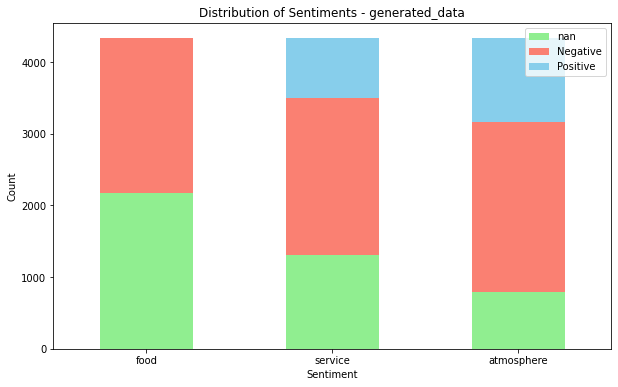

          food  service  atmosphere
Negative  2470     2459        2467
NaN       2290     1913        1723
Positive  1236     1624        1806


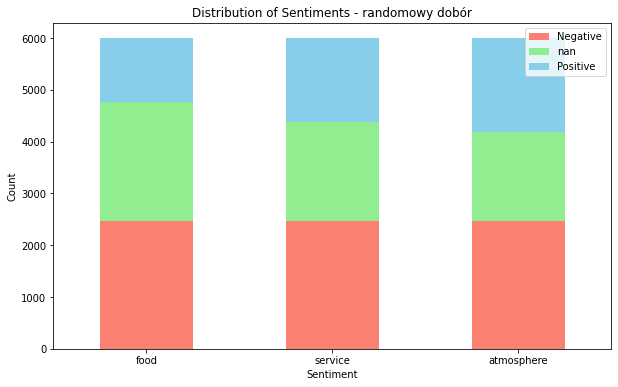

In [56]:
def draw_distribution_plot(df,title_):
    sentiment_distribution = df[['food', 'service', 'atmosphere']].apply(lambda x: x.value_counts(dropna=False))
    print(sentiment_distribution)
    sentiment_distribution = sentiment_distribution.T
    colors = {
        'NaN': 'gray',
        'Negative': 'salmon',
        'Positive': 'skyblue'
    }
    sentiment_distribution.plot(kind='bar', stacked=True,
                                color=[colors.get(val, 'lightgreen') for val in sentiment_distribution.columns],
                                figsize=(10, 6))
    plt.title(f'Distribution of Sentiments - {title_}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()


draw_distribution_plot(clean_df, "clean data")
draw_distribution_plot(generated_df, "generated_data")

def count_sentiments(df):
    results = []
    for column in ['food', 'service', 'atmosphere']:
        none_count = df[column].isna().sum()  # Liczba wartości None
        negative_count = (df[column] == 'Negative').sum()  # Liczba "Negative"
        positive_count = (df[column] == 'Positive').sum()  # Liczba "Positive"
        results.append([none_count, negative_count, positive_count])
    return results

def Equality_coefiecent(counts_matrix):
    total_sum = 0
    for lst in counts_matrix:
        max_diff = max(lst) - min(lst)
        sum_elements = sum(lst)
        total_sum += max_diff / sum_elements
    return total_sum

def reschape_df_choose_the_best(original_records, additional_records, iterations=20, max_percent_of_new_records = 25,
                                base_length_on_original_df = True):

    best_coef = float('inf')
    best_df = None
    if base_length_on_original_df:
        max_new_records_numbers = int( len(original_records)/100 * max_percent_of_new_records)
    else:
        max_new_records_numbers = int( len(additional_records)/100 * max_percent_of_new_records)

    for i in range(iterations):
        random_sample = additional_records.sample(n=max_new_records_numbers)
        df_combined = pd.concat([original_records, random_sample], axis=0)
        counts_matrix = count_sentiments(df_combined)
        coef = Equality_coefiecent(counts_matrix)
        if best_df is None or coef < best_coef:
            best_df = df_combined
            best_coef = coef

    draw_distribution_plot(best_df,"randomowy dobór")
    return best_df

df = reschape_df_choose_the_best(clean_df,generated_df,1,100,False)
df.to_csv('../raw_data/random_choice_data.csv', index=False)




# Word Cloud for Sentiment Analysis
Purpose:

This section generates a word cloud to visualize the most frequently occurring terms in reviews associated with a specific sentiment (e.g., "Positive" for food).

Highlight Common Terms: It helps quickly identify the most frequent and relevant words tied to a particular sentiment.
Sentiment-Specific Insights: Analyzing positive, negative, or other sentiments separately reveals how language usage varies across sentiments.
How It Works:

1. Filtering Reviews: Selects reviews matching the specified sentiment in the target category.
2. Preprocessing: Converts text to lowercase and combines all tokens into a single text corpus.
3. Visualization: Creates a word cloud, where term sizes represent their frequency.

This visualization provides an intuitive summary of the key terms associated with specific sentiments, offering insights into language patterns and customer feedback.

In [57]:
from wordcloud import WordCloud, STOPWORDS

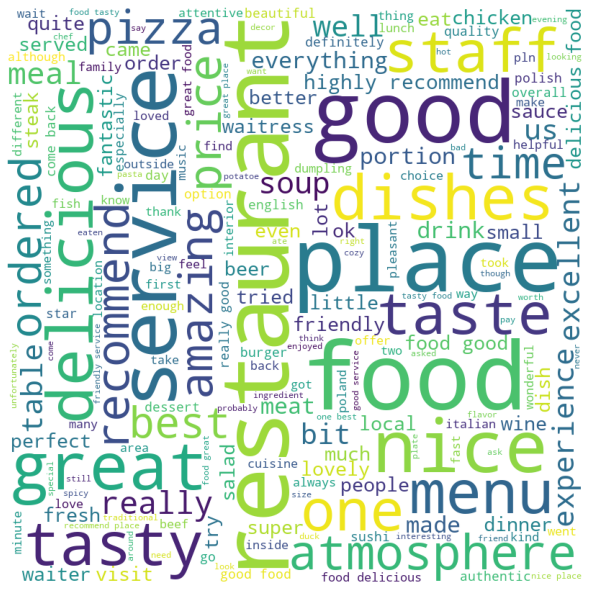

In [58]:
# Generate word cloud
def word_cloud_plot(df, sentiment_col, sentiment_value):
    comment_words = ' '
    stopwords = set(STOPWORDS)
    filtered_reviews = df[df[sentiment_col] == sentiment_value]['text'].dropna()

    for review in filtered_reviews:
        tokens = str(review).lower().split()
        comment_words += ' '.join(tokens) + ' '

    wordcloud = WordCloud(width=800, height=800, 
                          background_color='white', 
                          stopwords=stopwords, 
                          min_font_size=10).generate(comment_words)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

# Example: Generate word cloud for positive food reviews
word_cloud_plot(df, 'food', 'Positive')

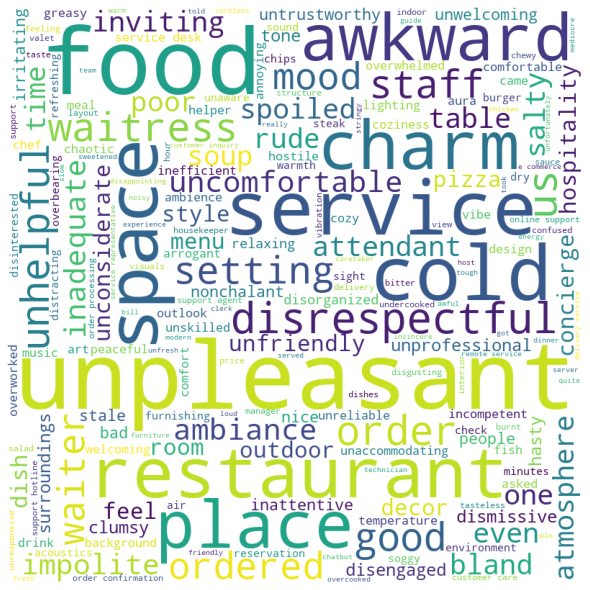

In [59]:
word_cloud_plot(df, 'service', 'Negative')

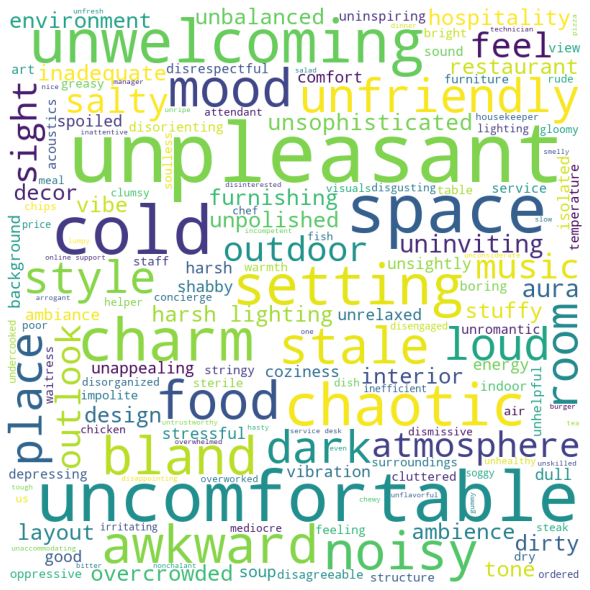

In [60]:
word_cloud_plot(df, 'atmosphere', 'Negative')

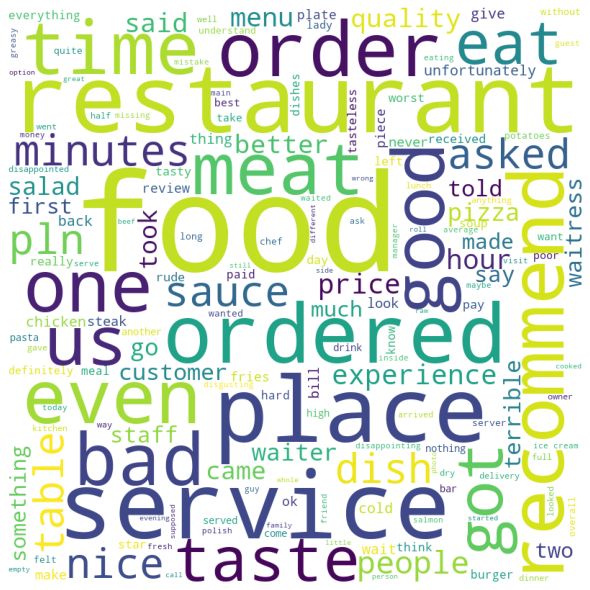

In [61]:
# word cloud for reviews with one star
word_cloud_plot(df, 'rating', 1)

# Analyzing and Visualizing Top TF-IDF Terms
Purpose:

This section identifies and visualizes the top terms based on their TF-IDF scores. TF-IDF helps determine the importance of words or phrases by balancing their frequency in individual reviews with their rarity across all reviews.

Identify Key Features: The most important terms help understand dominant themes or sentiments in the dataset.
Guide Further Analysis: High-scoring terms can inform feature selection for machine learning models.
How It Works:

1. TF-IDF Vectorization: Transforms the cleaned text into numerical features, focusing on the top 50 terms with unigrams and bigrams.
2. Summarization: Computes the sum of TF-IDF scores for each term across all reviews.
3. Visualization: Displays the top 10 terms as a bar chart, showing their relative importance.

This analysis provides insights into the dataset’s linguistic patterns and highlights terms likely to influence sentiment or topic classification.

Top 10 terms by TF-IDF scores:
food          422.130033
not           345.215230
good          313.190837
place         296.367877
service       288.138672
nice          258.283114
great         257.249202
restaurant    243.778808
delicious     241.977940
recommend     222.700154
dtype: float64


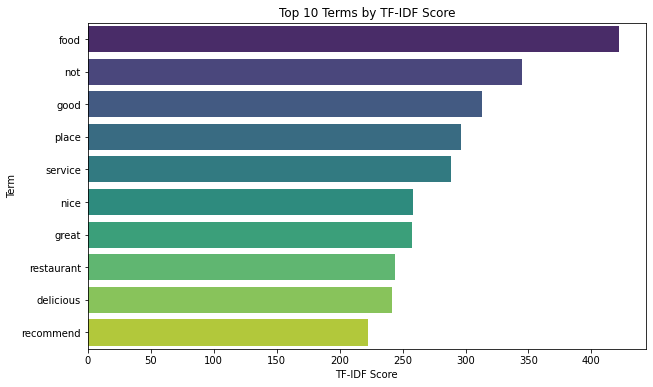

In [62]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("../raw_data/filtered_data.csv")

# Preprocess text
def preprocess_text(text):
    # Remove punctuation, convert to lowercase
    return " ".join(word.lower() for word in str(text).split() if word.isalpha())

df['cleaned_text'] = df['text'].apply(preprocess_text)

# Generate TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=50, ngram_range=(1, 2))  # You can adjust max_features and ngram_range
tfidf_matrix = vectorizer.fit_transform(df['cleaned_text'])

# Convert to DataFrame for analysis
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Summarize top terms
top_terms = tfidf_df.sum(axis=0).sort_values(ascending=False).head(10)
print("Top 10 terms by TF-IDF scores:")
print(top_terms)

# Visualize top terms
plt.figure(figsize=(10, 6))
sns.barplot(x=top_terms.values, y=top_terms.index, palette='viridis')
plt.title('Top 10 Terms by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Term')
plt.show()


# Word Cloud Visualization of TF-IDF Terms
Purpose:

This section uses a word cloud to visualize the most important terms based on their TF-IDF weights. TF-IDF assigns higher weights to terms that are frequent in individual documents but rare across the entire dataset, highlighting their relevance.

Intuitive Representation: Word clouds provide a quick and visually appealing way to understand the most influential terms.
Feature Insights: By scaling term sizes based on their weights, this visualization emphasizes terms with the highest impact on the dataset.
How It Works:

1. Input: A dictionary of terms and their corresponding TF-IDF weights.
2. Output: A word cloud where term sizes reflect their importance.
3. Interpretation: Larger terms in the word cloud are more significant based on their TF-IDF scores.

This visualization helps interpret text data and identify key terms that are likely to influence downstream analysis or model predictions.

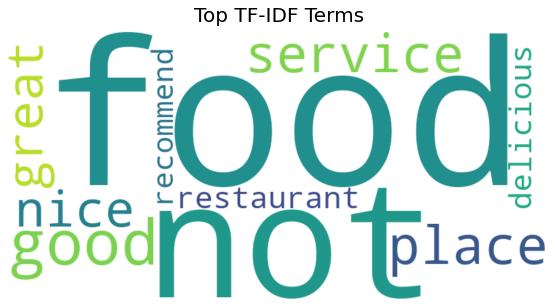

In [63]:
# Example: Generate word cloud with TF-IDF weights
def plot_tfidf_wordcloud(tfidf_df, title):
    term_weights = {term: weight for term, weight in tfidf_df.items()}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(term_weights)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# Create word cloud for top terms
plot_tfidf_wordcloud(top_terms, "Top TF-IDF Terms")

# Identifying Most Correlated Terms
This section analyzes the most significant words and phrases (unigrams, bigrams, trigrams) correlated with target categories (e.g., "service" sentiment). Using TF-IDF for feature extraction and Chi-Squared for statistical analysis, we identify terms most strongly associated with each category.

This helps:

- Highlight important features for category differentiation.
- Provide insights into language patterns and text interpretation.
- Improve feature engineering and model performance.

The results offer a clearer understanding of how specific terms influence categorization and sentiment.

In [64]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

# Load dataset
df = pd.read_csv("../raw_data/clean_data.csv")

# Preprocess text
def preprocess_text(text):
    # Remove punctuation, convert to lowercase
    return " ".join(word.lower() for word in str(text).split() if word.isalpha())

df['cleaned_text'] = df['text'].apply(preprocess_text)

# Target categories (example: 'food', 'service', 'atmosphere')
categories = ['food', 'service', 'atmosphere']
category_col = 'service'  # Choose the target category for analysis

# for category_col in categories:
category_to_id = {cat: idx for idx, cat in enumerate(df[category_col].dropna().unique())}
df[f'{category_col}_category_id'] = df[category_col].map(category_to_id)

# Generate TF-IDF features
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)
features = tfidf.fit_transform(df['cleaned_text'])
labels = df[f'{category_col}_category_id']

# Analyze top N correlated terms for each category
N = 5  # Number of terms to display
for category, category_id in category_to_id.items():
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])  # Sort features by chi-squared scores
    feature_names = np.array(tfidf.get_feature_names_out())[indices]

    # Extract unigrams, bigrams, and trigrams
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]

    print(f"Most correlated terms with '{category}' sentiment in {category_col}:")
    print("  1. Most correlated unigrams:\n--> {}".format('\n--> '.join(unigrams[-N:])))
    print("  2. Most correlated bigrams:\n--> {}".format('\n--> '.join(bigrams[-N:])))
    print("  3. Most correlated trigrams:\n--> {}".format('\n--> '.join(trigrams[-N:])))
    print("___________________________________________________________________________\n")

Most correlated terms with 'Positive' sentiment in service:
  1. Most correlated unigrams:
--> not
--> staff
--> nan
--> friendly
--> service
  2. Most correlated bigrams:
--> friendly service
--> good service
--> great service
--> nice service
--> friendly staff
  3. Most correlated trigrams:
--> definitely come back
--> would highly recommend
--> highly recommend restaurant
--> highly recommend place
--> food great service
___________________________________________________________________________

Most correlated terms with 'Negative' sentiment in service:
  1. Most correlated unigrams:
--> not
--> waited
--> bad
--> rude
--> minutes
  2. Most correlated bigrams:
--> not want
--> service not
--> waiting time
--> not recommend
--> not even
  3. Most correlated trigrams:
--> would highly recommend
--> would definitely recommend
--> traditional polish food
--> definitely come back
--> highly recommend place
___________________________________________________________________________

